# Skin lesion classification of dermoscopic images using machine learning and convolutional neural network

19 December 2022

https://www.nature.com/articles/s41598-022-22644-9#Tab7

https://aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=561

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import glob
import cv2
import numpy as np
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder

from skimage.feature import graycomatrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Concatenate

In [9]:
def get_path_and_label(src_path, num_files_per_folder):
    image_paths = []
    lesions = []

    for root, dirs, files in tqdm(os.walk(src_path), desc='Walking directories', unit=' dir'):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            image_files = sorted(glob.glob(os.path.join(dir_path, '*.jpg')))

            for image_file in image_files[:num_files_per_folder]:
                filename = os.path.basename(image_file)
                parts = filename.split('_')
                if len(parts) >= 3:
                    second_part = parts[2]
                    lesions.append(second_part)
                    image_paths.append(image_file)

    return image_paths, lesions

def preprocess_images(image_paths):
    images = []
    gray_images = []

    for image_path in tqdm(image_paths, desc='Preprocessing Images'):
        image = cv2.imread(image_path)
        image = cv2.resize(image, target_size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        images.append(image)
        gray_images.append(gray_image)

    return np.array(images), np.array(gray_images)

def extract_color_histograms(images):
    histograms = np.zeros((images.shape[0], 512))

    for i, image in tqdm(enumerate(images), desc='Extracting Color Histograms'):
        histogram = cv2.calcHist([image], [0, 1, 2], None,[8 ,8 ,8 ], [0 ,256 ,0 ,256 ,0 ,256])
        histogram = cv2.normalize(histogram,histogram).flatten()

        histograms[i] = histogram

    return histograms

def extract_hu_moments(gray_images):
    moments_list = []

    for gray_image in tqdm(gray_images, desc='Extracting Hu Moments'):
        moments = cv2.HuMoments(cv2.moments(gray_image)).flatten()

        moments_list.append(moments)

    return np.array(moments_list)

def extract_haralick_textures(gray_images):
    textures_list = []

    for gray_image in tqdm(gray_images, desc='Extracting Haralick Textures'):
        texture_matrixes= graycomatrix(gray_image,distances=[1],angles=[0],symmetric=True,normed=True)
        haralick_features_mean= np.mean(texture_matrixes,axis=(0,1))

        textures_list.append(haralick_features_mean.flatten())

    return np.array(textures_list)

def extract_features(image_paths):
    images, gray_images = preprocess_images(image_paths)
    color_histograms = extract_color_histograms(images)
    hu_moments = extract_hu_moments(gray_images)
    haralick_textures = extract_haralick_textures(gray_images)

    feature_vectors = np.concatenate([color_histograms,
                                      hu_moments,
                                      haralick_textures], axis=1)

    return feature_vectors

def create_dataset(image_paths, image_feature_vectors, lesions):
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(lesions)

    num_classes = len(encoder.classes_)
    one_hot_labels = tf.one_hot(encoded_labels, depth=num_classes)

    dataset = tf.data.Dataset.from_tensor_slices(({"image_input": image_paths,
                                                   "global_feature_input": image_feature_vectors},
                                                  one_hot_labels))

    def load_and_preprocess(inputs_dict, label):
        img = tf.io.read_file(inputs_dict["image_input"])
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, target_size)
        img = img / 255.0

        return {"image_input": img,
                "global_feature_input": inputs_dict["global_feature_input"]}, label

    dataset = dataset.map(load_and_preprocess)

    return dataset

# camera cat

In [7]:
src_path = '/content/drive/Shareddrives/반려묘/일반카메라/Training'
num_files_per_folder = 3000

image_paths, lesions = get_path_and_label(src_path, num_files_per_folder)

Walking directories: 14 dir [00:04,  3.36 dir/s]


In [10]:
target_size = (96, 96)

image_feature_vectors = extract_features(image_paths)

Preprocessing Images: 100%|██████████| 29490/29490 [56:43<00:00,  8.66it/s]
Extracting Color Histograms: 29490it [00:01, 25359.87it/s]
Extracting Haralick Textures: 100%|██████████| 29490/29490 [00:09<00:00, 3019.80it/s]


In [11]:
buffer_size = 1000
batch_size = 64

dataset = create_dataset(image_paths, image_feature_vectors, lesions)
dataset = dataset.shuffle(buffer_size).batch(batch_size)

In [12]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = int(test_ratio * dataset_size)

train_dataset = dataset.take(train_size)
val_dataset_temp = dataset.skip(train_size)

val_dataset = val_dataset_temp.take(val_size)
test_dataset = val_dataset_temp.skip(val_size)

In [13]:
image_input = Input(shape=(96, 96, 3), name='image_input')
x = Conv2D(32, (3, 3), padding='same', activation='relu')(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3 , 3))(x)

x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2 , 2))(x)

x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2 , 2))(x)

x = Dropout(0.25)(x)

global_feature_input = Input(shape=(520,), name='global_feature_input')

combined_features= Concatenate()([Flatten()(x), global_feature_input])

combined_features= Dense(1024, activation='relu')(combined_features)
combined_features= BatchNormalization ()(combined_features)
combined_features= Dropout(0.5)(combined_features)

outputs= Dense(4, activation='softmax')(combined_features)

model= Model(inputs=[image_input, global_feature_input], outputs=outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
import logging

logging.basicConfig(filename='training_errors.log', level=logging.ERROR)

try:
    for batch_idx, (batch_images, batch_labels) in enumerate(train_dataset):
        try:
            for image_idx in range(len(batch_images)):
                history = model.fit(
                    batch_images[image_idx],
                    batch_labels[image_idx],
                    epochs=1,
                    batch_size=1
                )
        except Exception as e:
            logging.error(f"Error occurred during training. Batch index: {batch_idx}, Image index: {image_idx}")
except Exception as e:
    logging.error(f"Error occurred during processing of batch. Batch index: {batch_idx}")


ERROR:root:Error occurred during training. Batch index: 0, Image index: 0
ERROR:root:Error occurred during training. Batch index: 1, Image index: 0
ERROR:root:Error occurred during training. Batch index: 2, Image index: 0
ERROR:root:Error occurred during training. Batch index: 3, Image index: 0
ERROR:root:Error occurred during training. Batch index: 4, Image index: 0
ERROR:root:Error occurred during training. Batch index: 5, Image index: 0
ERROR:root:Error occurred during training. Batch index: 6, Image index: 0
ERROR:root:Error occurred during training. Batch index: 7, Image index: 0
ERROR:root:Error occurred during training. Batch index: 8, Image index: 0
ERROR:root:Error occurred during training. Batch index: 9, Image index: 0
ERROR:root:Error occurred during training. Batch index: 10, Image index: 0
ERROR:root:Error occurred during training. Batch index: 11, Image index: 0
ERROR:root:Error occurred during training. Batch index: 12, Image index: 0
ERROR:root:Error occurred during tr

Image:
[[[[0.75       0.75       0.75784314]
   [0.8122549  0.79656863 0.79264706]
   [0.6041667  0.5370098  0.48382354]
   ...
   [0.9115196  0.8593137  0.81764704]
   [0.81078434 0.7269608  0.68333334]
   [0.7705882  0.66764706 0.59460783]]

  [[0.7137255  0.7058824  0.70980394]
   [0.79534316 0.7757353  0.7632353 ]
   [0.65343136 0.5632353  0.5004902 ]
   ...
   [0.7345588  0.6046569  0.5208333 ]
   [0.6105392  0.43259802 0.3409314 ]
   [0.6367647  0.45637256 0.3634804 ]]

  [[0.7732843  0.76936275 0.7512255 ]
   [0.89460784 0.87892157 0.84117645]
   [0.7147059  0.6284314  0.5397059 ]
   ...
   [0.6767157  0.5110294  0.43504903]
   [0.69436276 0.53357846 0.4522059 ]
   [0.6877451  0.5269608  0.44558823]]

  ...

  [[0.53088236 0.42892158 0.37009802]
   [0.3992647  0.29730392 0.23848039]
   [0.49460784 0.3764706  0.3230392 ]
   ...
   [0.7745098  0.7588235  0.7470588 ]
   [0.7764706  0.75686276 0.7411765 ]
   [0.75416666 0.7345588  0.71887255]]

  [[0.57034314 0.46838236 0.40563726]


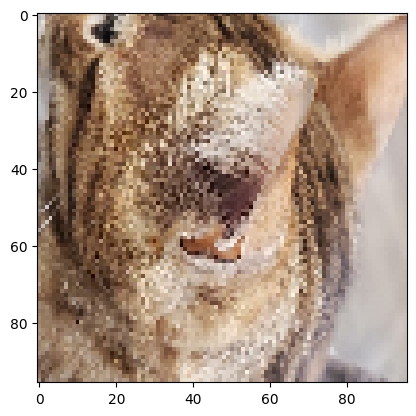

In [33]:
import matplotlib.pyplot as plt

first_batch = dataset.batch(batch_size).take(1)

for batch in first_batch:
    batch_images = batch[0]["image_input"].numpy()
    batch_labels = batch[1].numpy()

    first_image = batch_images[0]
    first_label = batch_labels[0]

    image_path = image_paths[0]

    print("Image:")
    print(first_image)

    print("Label:")
    print(first_label)

    print("Image path:")
    print(image_path)

    plt.imshow(first_image[0])
    plt.show()

In [15]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    batch_size=64
)

Epoch 1/150
294/368 [======================>.......] - ETA: 13s - loss: 1.2711 - accuracy: 0.5806

InvalidArgumentError: ignored

In [ ]:
y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

print(confusion_matrix(y_true_classes, y_pred_classes))

roc_auc = roc_auc_score(y_true, y_pred , multi_class='ovr')
print('ROC-AUC score:', roc_auc)

In [ ]:
# TensorFlow Lite 모델로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# 변환된 모델을 파일로 저장
with open('Mk-1.tflite', 'wb') as f:
    f.write(tflite_model)

# microscope cat

In [ ]:
from tensorflow.keras.layers import PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Concatenate, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mean_squared_error

def inception_module(input_layer, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), activation='relu')(input_layer)
    conv3x3_reduce = Conv2D(filters[1], (1, 1), activation='relu')(input_layer)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)
    conv5x5_reduce = Conv2D(filters[3], (1, 1), activation='relu')(input_layer)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_layer)
    maxpool_conv = Conv2D(filters[5], (1, 1), activation='relu')(maxpool)
    inception_output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, maxpool_conv])
    return inception_output

# Input
input_shape = (128, 128, 3)
input_layer = Input(shape=input_shape)

# Inception block
inception_output = inception_module(input_layer, filters=[64, 128, 192, 32, 96, 64])
inception_output = inception_module(inception_output, filters=[64, 128, 192, 32, 96, 64])
# Add more inception modules if needed

# Primary Capsule layer
primary_capsules = Conv2D(32, (1, 1), activation='relu')(inception_output)

# Higher Capsule layers
# (Add imperative routing mechanism layers here)

# PReLU activation for routing
higher_capsules_prelu = PReLU()(higher_capsules)

# Flatten and Fully Connected layers
capsule_flatten = Flatten()(higher_capsules_prelu)  # Flatten higher capsules
output_layer = Dense(2, activation='softmax')(capsule_flatten)  # Two capsules: parasitized and uninfected

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with Adam optimizer and custom loss function
optimizer = Adam(learning_rate=0.007, beta_1=0.8)
loss_fn = custom_loss_function # Define the custom loss function as described in the paper
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Print the model summary
model.summary()